In [2]:
from src.data.dataset_reader import DatasetReader
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
data_folder = Path("../data/raw").resolve()

#deplay = DatasetReader(data_folder).get_data_csv('deplay.csv')


ModuleNotFoundError: No module named 'src'

In [17]:
deplay_week = DatasetReader(data_folder).get_data_csv('deplay_week_treated.csv')

In [3]:
import pandas as pd
deplay_week = pd.read_csv('../data/raw/deplay_week_treated.csv')    

In [4]:
deplay_week.drop(['Unnamed: 0', 'Unnamed: 15', 'Unnamed: 17'], axis=1, inplace=True)

In [5]:

deplay_week['week'] = deplay_week['week'].str.replace('Week', '')

In [6]:
for column in deplay_week.columns:
    if deplay_week[column].dtype == 'object':
        deplay_week[column] = deplay_week[column].str.replace('€', '')




In [7]:
deplay_week.head()

,Product,week,Sale price incl. VAT (Value Added Tax),Sale price excl. VAT,Purchase price per piece,Sales BE,Sales NL,Sales,Revenue BE,Revenue NL,...,Saleable returns,Unsaleable returns,exchange items,Total returns,Total return costs,Total SP costs,Net profit,Net profit per peace,Profit Margin,ROI
0,Tablet PRO Blauw,1,180.00,148.76,85.23,8.0,22.0,30.0,"1,191.72","3,271.02",...,NaN,9.0,NaN,9.0,791.01,0.00,559.23,18.64,12.53%,21.87%
1,Tablet PRO Blauw,2,184.00,152.07,85.23,3.0,22.0,25.0,456.21,"3,345.53",...,NaN,10.0,NaN,10.0,878.90,0.00,330.43,13.22,8.69%,15.51%
2,Tablet PRO Blauw,3,184.00,152.07,85.23,3.0,17.0,20.0,456.21,"2,585.19",...,NaN,5.0,NaN,5.0,439.45,0.00,522.45,26.12,17.18%,30.65%
3,Tablet PRO Blauw,4,184.00,152.07,85.23,3.0,33.0,36.0,456.21,"5,018.28",...,NaN,7.0,NaN,7.0,615.23,0.00,"1,137.18",31.59,20.77%,37.06%
4,Tablet PRO Blauw,5,188.25,155.58,85.23,3.0,17.0,20.0,468.60,"2,643.01",...,NaN,5.0,NaN,5.0,439.45,0.00,601.31,30.07,19.32%,35.28%


In [8]:
# drop this columns: 'Sales BE', 'Sales NL', 'Revenue BE', 'Revenue NL'
deplay_week.drop(['Sales BE', 'Sales NL', 'Revenue BE', 'Revenue NL'], axis=1, inplace=True)

In [9]:
deplay_week.head()

,Product,week,Sale price incl. VAT (Value Added Tax),Sale price excl. VAT,Purchase price per piece,Sales,Revenue excl. VAT,Customer visits,Conversion %,Bol Costs,...,Saleable returns,Unsaleable returns,exchange items,Total returns,Total return costs,Total SP costs,Net profit,Net profit per peace,Profit Margin,ROI
0,Tablet PRO Blauw,1,180.00,148.76,85.23,30.0,"4,462.74",251,11.95%,359.70,...,NaN,9.0,NaN,9.0,791.01,0.00,559.23,18.64,12.53%,21.87%
1,Tablet PRO Blauw,2,184.00,152.07,85.23,25.0,"3,801.74",949,2.63%,304.76,...,NaN,10.0,NaN,10.0,878.90,0.00,330.43,13.22,8.69%,15.51%
2,Tablet PRO Blauw,3,184.00,152.07,85.23,20.0,"3,041.40",975,2.05%,243.80,...,NaN,5.0,NaN,5.0,439.45,0.00,522.45,26.12,17.18%,30.65%
3,Tablet PRO Blauw,4,184.00,152.07,85.23,36.0,"5,474.49",796,4.52%,438.85,...,NaN,7.0,NaN,7.0,615.23,0.00,"1,137.18",31.59,20.77%,37.06%
4,Tablet PRO Blauw,5,188.25,155.58,85.23,20.0,"3,111.61",672,2.98%,248.05,...,NaN,5.0,NaN,5.0,439.45,0.00,601.31,30.07,19.32%,35.28%


In [10]:
# drop this columns Sales België	Sales Nederland
deplay_week.drop(['Sales België', 'Sales Nederland'], axis=1, inplace=True)

In [65]:

# sum row wise Shipping costs  BE and Shipping costs  NL to create a shipping_costs column

#deplay_week['shipping_costs'] = deplay_week['Shipping costs  BE'] + deplay_week['Shipping costs  NL']



In [11]:
deplay_week['Conversion %'] = deplay_week['Conversion %'].str.replace('%', '')

In [12]:
# remove % sign from these columns Profit Margin	ROI
deplay_week['Profit Margin'] = deplay_week['Profit Margin'].str.replace('%', '')
deplay_week['ROI'] = deplay_week['ROI'].str.replace('%', '')

In [13]:
# convert to float the following columns: 'Sale price incl. VAT (Value Added Tax)',
       #'Sale price excl. VAT', 'Purchase price per piece', 'Sales',
       #'Revenue excl. VAT', 'Customer visits', 'Conversion %', 'Bol Costs',
       #'Sales België', 'Sales Nederland', 'Shipping costs  BE',
       #'Shipping costs  NL', 'Total gross profit', 'Gross profit per piece',
       #'Saleable returns', 'Unsaleable returns', 'exchange items',
       #'Total returns', 'Total return costs', 'Total SP costs', 'Net profit',
       #'Net profit per peace', 'Profit Margin', 'ROI'

columns_to_convert = [
    'Sale price incl. VAT (Value Added Tax)', 'Sale price excl. VAT', 
    'Purchase price per piece', 'Sales', 'Revenue excl. VAT', 
    'Customer visits', 'Conversion %', 'Bol Costs', 'Shipping costs  BE', 'Shipping costs  NL', 
    'Total gross profit', 'Gross profit per piece', 'Saleable returns', 
    'Unsaleable returns', 'exchange items', 'Total returns', 
    'Total return costs', 'Total SP costs', 'Net profit', 
    'Net profit per peace', 'Profit Margin', 'ROI'
]

# Convert columns to float after cleaning the strings
for column in columns_to_convert:
    if deplay_week[column].dtype == 'object':  # Check if column contains strings
        deplay_week[column] = deplay_week[column].str.replace(',', '').str.replace('- ', '-').str.strip()
    deplay_week[column] = deplay_week[column].astype(float)






In [28]:
deplay_week.head()

,Product,week,Sale price incl. VAT (Value Added Tax),Sale price excl. VAT,Purchase price per piece,Sales,Revenue excl. VAT,Customer visits,Conversion %,Bol Costs,Shipping costs BE,Shipping costs NL,Total gross profit,Gross profit per piece,Saleable returns,Unsaleable returns,exchange items,Total returns,Total return costs,Total SP costs,Net profit,Net profit per peace,Profit Margin,ROI
0,Tablet PRO Blauw,1,180.00,148.76,85.23,30.0,4462.74,251.0,11.95,359.70,54.00,141.90,1350.24,45.01,NaN,9.0,NaN,9.0,791.01,0.0,559.23,18.64,12.53,21.87
1,Tablet PRO Blauw,2,184.00,152.07,85.23,25.0,3801.74,949.0,2.63,304.76,21.45,135.45,1209.33,48.37,NaN,10.0,NaN,10.0,878.90,0.0,330.43,13.22,8.69,15.51
2,Tablet PRO Blauw,3,184.00,152.07,85.23,20.0,3041.40,975.0,2.05,243.80,21.45,109.65,961.90,48.09,NaN,5.0,NaN,5.0,439.45,0.0,522.45,26.12,17.18,30.65
3,Tablet PRO Blauw,4,184.00,152.07,85.23,36.0,5474.49,796.0,4.52,438.85,21.45,193.50,1752.41,48.68,NaN,7.0,NaN,7.0,615.23,0.0,1137.18,31.59,20.77,37.06
4,Tablet PRO Blauw,5,188.25,155.58,85.23,20.0,3111.61,672.0,2.98,248.05,21.45,96.75,1040.76,52.04,NaN,5.0,NaN,5.0,439.45,0.0,601.31,30.07,19.32,35.28


In [14]:
deplay_week['shipping_costs'] = deplay_week['Shipping costs  BE'] + deplay_week['Shipping costs  NL']

In [15]:
deplay_week.drop(['Shipping costs  BE', 'Shipping costs  NL'], axis=1, inplace=True)

In [16]:
deplay_week.head()

,Product,week,Sale price incl. VAT (Value Added Tax),Sale price excl. VAT,Purchase price per piece,Sales,Revenue excl. VAT,Customer visits,Conversion %,Bol Costs,...,Unsaleable returns,exchange items,Total returns,Total return costs,Total SP costs,Net profit,Net profit per peace,Profit Margin,ROI,shipping_costs
0,Tablet PRO Blauw,1,180.00,148.76,85.23,30.0,4462.74,251.0,11.95,359.70,...,9.0,NaN,9.0,791.01,0.0,559.23,18.64,12.53,21.87,195.90
1,Tablet PRO Blauw,2,184.00,152.07,85.23,25.0,3801.74,949.0,2.63,304.76,...,10.0,NaN,10.0,878.90,0.0,330.43,13.22,8.69,15.51,156.90
2,Tablet PRO Blauw,3,184.00,152.07,85.23,20.0,3041.40,975.0,2.05,243.80,...,5.0,NaN,5.0,439.45,0.0,522.45,26.12,17.18,30.65,131.10
3,Tablet PRO Blauw,4,184.00,152.07,85.23,36.0,5474.49,796.0,4.52,438.85,...,7.0,NaN,7.0,615.23,0.0,1137.18,31.59,20.77,37.06,214.95
4,Tablet PRO Blauw,5,188.25,155.58,85.23,20.0,3111.61,672.0,2.98,248.05,...,5.0,NaN,5.0,439.45,0.0,601.31,30.07,19.32,35.28,118.20


In [17]:
deplay_week.shape

(996, 23)

In [18]:
# show duplicated rows
deplay_week[deplay_week.duplicated()].shape

(7, 23)

In [19]:
deplay_week.drop_duplicates(inplace=True)

In [20]:
deplay_week.to_csv('deplay_week_treated_chatgpt.csv')

# Test OOS Feature 

In [23]:
deplay_week.head()
data = deplay_week.copy()

In [24]:
cleaned_data = data.drop(columns=[ 'exchange items']).fillna(0)

Next, let's move to step 2 for feature engineering. We will create a 'Sales Velocity' feature, which will be Sales/Week for each product. This feature gives us a better understanding of how fast a product is selling

In [25]:
cleaned_data.dtypes
cleaned_data['week'] = cleaned_data['week'].astype(int)

In [26]:
# drop NaN values

cleaned_data.dropna(inplace=True)

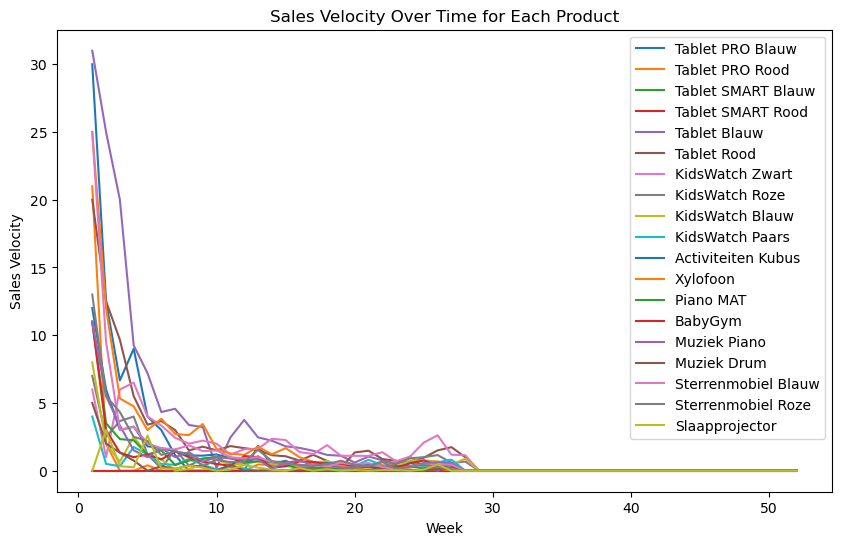

In [29]:
import matplotlib.pyplot as plt

# Feature Engineering
# Create 'Sales Velocity' = Sales/Week
cleaned_data['Sales Velocity'] = cleaned_data['Sales'] / cleaned_data['week']

# Visualize 'Sales Velocity' for each product
plt.figure(figsize=(10, 6))
for product in cleaned_data['Product'].unique():
    product_data = cleaned_data[cleaned_data['Product'] == product]
    plt.plot(product_data['week'], product_data['Sales Velocity'], label=product)

plt.xlabel('Week')
plt.ylabel('Sales Velocity')
plt.title('Sales Velocity Over Time for Each Product')
plt.legend()
plt.show()


The graph shows the 'Sales Velocity' over time for each product.

Sales Velocity: Indicates how fast a product is selling (Sales/Week).
Customer Value: Helps in understanding which products are moving faster and may go out of stock soon.

In [30]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Initialize linear regression model
model = LinearRegression()

# Initialize a dictionary to store the model for each product
product_models = {}

# Initialize a dictionary to store the predicted 'Sales Velocity' for the next week
predicted_velocity = {}

# Loop through each product to fit a model and make a prediction
for product in cleaned_data['Product'].unique():
    product_data = cleaned_data[cleaned_data['Product'] == product]
    
    # Prepare the data for modeling
    X = product_data['week'].values.reshape(-1, 1)
    y = product_data['Sales Velocity'].values
    
    # Fit the model
    model.fit(X, y)
    
    # Store the model
    product_models[product] = model
    
    # Predict 'Sales Velocity' for the next week
    next_week = np.array([[product_data['week'].max() + 1]])
    predicted_velocity[product] = model.predict(next_week)[0]

# Show the predicted 'Sales Velocity' for the next week for each product
predicted_velocity


{'Tablet PRO Blauw': -2.3711375549908524,
 'Tablet PRO Rood': -0.8730521923007153,
 'Tablet SMART Blauw': 0.0,
 'Tablet SMART Rood': 0.0,
 'Tablet Blauw': -3.7481550147921077,
 'Tablet Rood': -2.046247777239273,
 'KidsWatch Zwart': -0.9964382416835287,
 'KidsWatch Roze': -0.6935520288238612,
 'KidsWatch Blauw': -0.5217352854976751,
 'KidsWatch Paars': -0.28307609336493766,
 'Activiteiten Kubus': -1.0935619375308399,
 'Xylofoon': -2.2171629525369427,
 'Piano MAT': -0.8563414049336076,
 'BabyGym': -0.7432989905241718,
 'Muziek Piano': -0.9463548552033356,
 'Muziek Drum': -0.3612889802948358,
 'Sterrenmobiel Blauw': -1.7644291291592893,
 'Sterrenmobiel Roze': -1.1241958661624696,
 'Slaapprojector': -0.22583899427348175}

The predicted 'Sales Velocity' for the next week for each product is calculated.


Negative values indicate a decreasing trend; those products are not at immediate risk of going out of stock.
A value of 0 suggests no change; still, these items should be monitored.
Customer Value:
Knowing these predictions helps in planning inventory and avoiding stock-outs

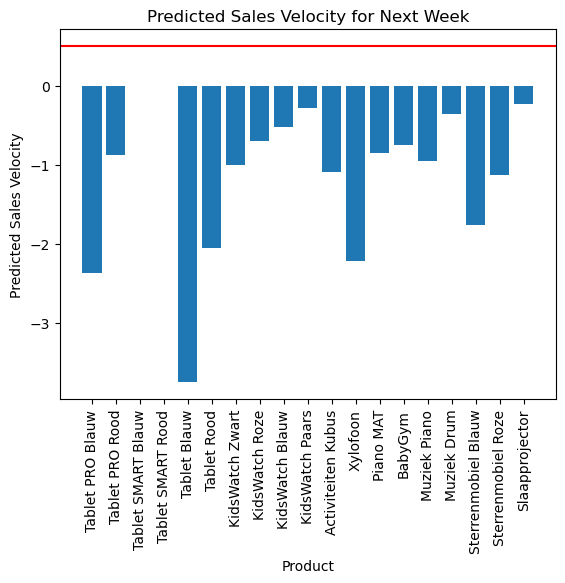

[]

In [31]:
# Thresholding: Identify items with predicted 'Sales Velocity' greater than a threshold as risky of going out of stock
# Given the data, we'll use a threshold of 0 for this PoC
threshold = 0.5

# Identify 'risky' items
risky_items = [product for product, velocity in predicted_velocity.items() if velocity > threshold]

# Visual representation
plt.bar(predicted_velocity.keys(), predicted_velocity.values())
plt.axhline(y=threshold, color='r', linestyle='-')
plt.xlabel('Product')
plt.ylabel('Predicted Sales Velocity')
plt.title('Predicted Sales Velocity for Next Week')
plt.xticks(rotation=90)
plt.show()

risky_items


The graph displays the predicted 'Sales Velocity' for the next week for each product. The red line represents the threshold.

Red Line: Threshold for identifying 'risky' items.
Risky Items:
None of the items have a predicted 'Sales Velocity' above the threshold, so currently, no items are identified as 'risky'.
Customer Value:
Inventory managers can focus on other tasks as no immediate action is required for restocking.

OOS pipeline

In [32]:
# import libraries
from numpy import mean
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

# Redefine the classes and pipeline for clarity and integration
class DataPreprocessor(BaseEstimator, TransformerMixin):
    """
    Class for data preprocessing: handling missing values and dropping irrelevant columns.
    """
    def __init__(self, drop_columns):
        self.drop_columns = drop_columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Drop irrelevant columns
        X = X.drop(columns=self.drop_columns)
        
        # Handle missing values
        X = X.fillna(0)
        
        return X


# Feature Engineering
class AdvancedFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['Sales Velocity'] = X['Sales'] / X['week'].replace(0, np.nan)
        X['Profit per Customer Visit'] = X['Net profit'] / X['Customer visits'].replace(0, np.nan)
        X.fillna(0, inplace=True)
        return X

# Model Training
class ModelTrainer(BaseEstimator, TransformerMixin):

    def __init__(self, model_type='linear'):
        if model_type == 'linear':
            self.model = LinearRegression()
        elif model_type == 'lgbm':
            self.model = LGBMRegressor()
        self.model_type = model_type
        self.trained_models = {}

    def fit(self, X, y, product_col):
        for product in product_col.unique():
            product_data = X[product_col == product]
            y_product = y.loc[product_data.index]
            self.model.fit(product_data, y_product)
            self.trained_models[product] = self.model
        return self

    def predict(self, X, product_col):
        predictions = {}
        for product in product_col.unique():
            product_data = X[product_col == product]
            if product in self.trained_models:
                model = self.trained_models[product]
                predictions[product] = model.predict(product_data)
        return predictions

# Main OOS Predictor Pipeline
class OOSPredictor:
    def __init__(self, threshold=0):
        self.pipeline = Pipeline([
            ('data_preprocessor', DataPreprocessor(['exchange items'])),
            ('feature_engineer', AdvancedFeatureEngineer()),
            ('model_trainer', ModelTrainer(model_type='lgbm'))
        ])
        self.threshold = threshold

    def fit(self, data):
        y = data['Sales Velocity']
        X = data.drop('Sales Velocity', axis=1)
        product_col = X['Product']
        X = pd.get_dummies(X, columns=['Product'], drop_first=True)
        self.pipeline.named_steps['model_trainer'].fit(X, y, product_col)

    def predict(self, data):
        X = data.drop('Sales Velocity', axis=1)
        product_col = X['Product']
        X = pd.get_dummies(X, columns=['Product'], drop_first=True)
        return self.pipeline.named_steps['model_trainer'].predict(X, product_col)

    def generate_alerts(self, predictions):
        alerts = {}
        for product, velocity in predictions.items():
            if velocity[-1] > self.threshold:
                alerts[product] = "At risk of going OOS"
        return alerts
    
    @staticmethod
    def evaluate(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        return mse, r2
    
    @staticmethod
    def plot_predictions(y_true, y_pred):
        plt.figure(figsize=(10, 6))
        plt.plot(y_true, label='Actual')
        plt.plot(y_pred, label='Predicted')
        plt.xlabel('Week')
        plt.ylabel('Sales Velocity')
        plt.title('Actual vs. Predicted Sales Velocity')
        plt.legend()
        plt.show()


# run pipeline
oos_predictor = OOSPredictor()
oos_predictor.fit(cleaned_data)
predictions = oos_predictor.predict(cleaned_data)
alerts = oos_predictor.generate_alerts(predictions)
# print alerts
print(alerts)
#oos_predictor.evaluate(cleaned_data['Sales Velocity'], predictions['Tablet PRO Blauw'])
#oos_predictor.plot_predictions(cleaned_data['Sales Velocity'], predictions['Tablet PRO Blauw'])

{}


: 

In [ ]:
# instanciate OOSPredictor with model_type='lgbm'


In [49]:


true_values_for_tablet_pro_blauw = cleaned_data[cleaned_data['Product'] == 'Tablet PRO Blauw']['Sales Velocity']


In [52]:
mse, r2 = oos_predictor.evaluate(true_values_for_tablet_pro_blauw, predictions['Tablet PRO Blauw'])

In [53]:
print(f'MSE: {mse}')
print(f'R2: {r2}')

MSE: 8.628705155092844e+28
R2: -4.0186204525637844e+27


In [56]:
predictions['Tablet PRO Blauw']
true_values_for_tablet_pro_blauw

0     30.000000
1     12.500000
2      6.666667
3      9.000000
4      4.000000
5      3.000000
6      1.142857
7      0.000000
8      0.000000
9      0.000000
10     0.000000
11     0.000000
12     1.846154
13     0.428571
14     0.733333
15     0.000000
16     0.000000
17     0.500000
18     0.473684
19     0.100000
20     0.333333
21     0.000000
22     0.000000
23     0.000000
24     0.000000
25     0.000000
26     0.000000
27     0.000000
28     0.000000
29     0.000000
30     0.000000
31     0.000000
32     0.000000
33     0.000000
34     0.000000
35     0.000000
36     0.000000
37     0.000000
38     0.000000
39     0.000000
40     0.000000
41     0.000000
42     0.000000
43     0.000000
44     0.000000
45     0.000000
46     0.000000
47     0.000000
48     0.000000
49     0.000000
50     0.000000
51     0.000000
Name: Sales Velocity, dtype: float64

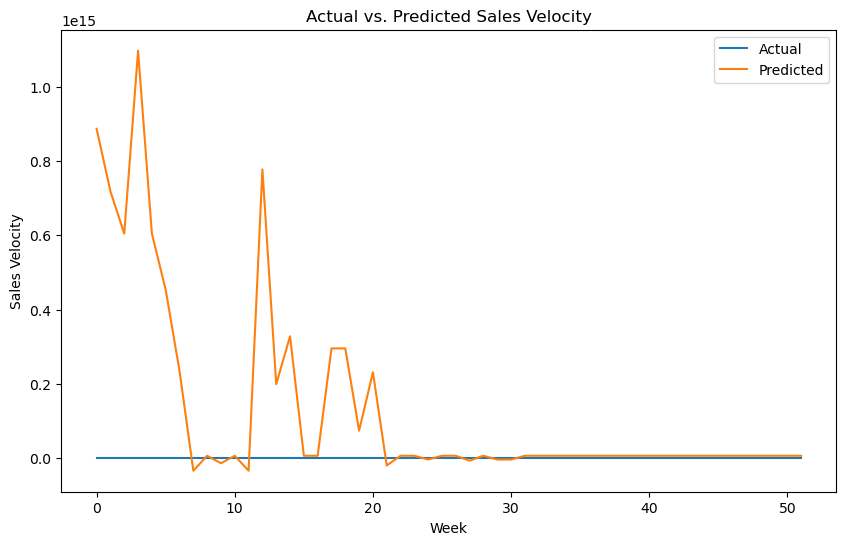

In [54]:
oos_predictor.plot_predictions(true_values_for_tablet_pro_blauw, predictions['Tablet PRO Blauw'])

In [1]:
plt.figure(figsize=(10, 6))
plt.plot(cleaned_data['week'], cleaned_data['Sales'], marker='o', color='blue')
plt.title('Sales Trend Over Weeks')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

In [2]:
sales = cleaned_data['Sales'].values

NameError: name 'cleaned_data' is not defined

In [40]:
# import libraries
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
# new approach
df = cleaned_data.copy()

# Feature Engineering
df['Sales_lag1'] = df['Sales'].shift(1)
df['Sales_rate_of_change'] = df['Sales'].pct_change()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Filling NaN values after creating lag and rate of change features
df.fillna(0, inplace=True)

# Splitting data: Using the first 4 weeks for training and the 5th week for testing
train = df[df['week'] < 5]
test = df[df['week'] == 5]

# Feature columns and target column
features = ['Sales_lag1', 'Sales_rate_of_change']
target = 'Sales'

# Model Training
model = LinearRegression()
model.fit(train[features], train[target])

# Predicting on the test set
test['Predicted_Sales'] = model.predict(test[features])

# MAE Calculation
mae = mean_absolute_error(test[target], test['Predicted_Sales'])

future_weeks = 4

# Create a DataFrame to store predicted sales for upcoming weeks
future_df = pd.DataFrame({
    'week': range(max(df['week']) + 1, max(df['week']) + 1 + future_weeks),
    'Sales_lag1': [df['Sales'].iloc[-1]] + [0] * (future_weeks - 1),
    'Sales_rate_of_change': [df['Sales_rate_of_change'].iloc[-1]] + [0] * (future_weeks - 1)
})
future_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Predicting sales for each future week
predicted_sales = []
for i in range(future_weeks):
    future_df['Predicted_Sales'] = model.predict(future_df[features])
    predicted_sales.append(future_df['Predicted_Sales'].iloc[i])
    
    # Update for next prediction
    if i < future_weeks - 1:
        future_df['Sales_lag1'].iloc[i + 1] = future_df['Predicted_Sales'].iloc[i]
        if future_df['Sales_lag1'].iloc[i] != 0:
            future_df['Sales_rate_of_change'].iloc[i + 1] = (future_df['Predicted_Sales'].iloc[i] - future_df['Sales_lag1'].iloc[i]) / future_df['Sales_lag1'].iloc[i]
        else:
            future_df['Sales_rate_of_change'].iloc[i + 1] = 0  # Or any other value that makes sense in your context


# Add the predicted sales to the future_df
future_df['Predicted_Sales'] = predicted_sales

# Establishing Stock Threshold
critical_stock_threshold = df['Sales'].mean()

# Identifying Potential OOS Weeks
future_df['Potential_OOS'] = future_df['Predicted_Sales'] > critical_stock_threshold

# Extracting potential OOS weeks
potential_oos_weeks = future_df[future_df['Potential_OOS']]['week'].tolist()

potential_oos_weeks

[53, 54, 55, 56]

In [32]:
from datetime import datetime, timedelta

# Set a base date
base_date = datetime.strptime("2023-01-01", "%Y-%m-%d")

# Convert integer weeks to datetime
df['ds'] = df['week'].apply(lambda x: base_date + timedelta(weeks=x-1))

# Now the 'ds' column is in datetime format suitable for Prophet

In [42]:
# prophet

single_product_data = df[df['Product'] == 'Tablet PRO Blauw'].copy()

14:02:29 - cmdstanpy - INFO - Chain [1] start processing
14:02:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 0.6124171230512752
Potential Out-of-Stock Weeks: []


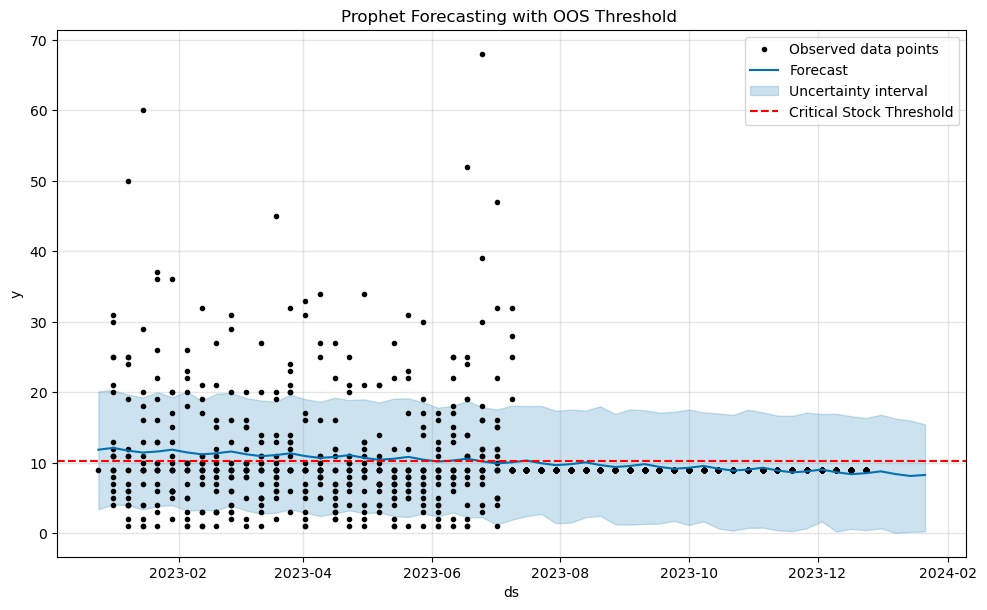

In [68]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prepare data for Prophet model#
df = cleaned_data.copy()
# Set a base date
base_date = datetime.strptime("2023-01-01", "%Y-%m-%d")

# Convert integer weeks to datetime
df['ds'] = df['week'].apply(lambda x: base_date + timedelta(weeks=x-1))
# Replace zeros with NaN for imputation
#df.loc[df['Sales'] == 0, 'Sales'] = np.nan
global_median = df.loc[df['Sales'] != 0, 'Sales'].median()
df['Sales'].replace(0, global_median, inplace=True)



#df['Sales'].fillna(df['Sales'].rolling(window=4, min_periods=1).mean(), inplace=True)



prophet_data = df[['ds', 'Sales']].rename(columns={'ds': 'ds', 'Sales': 'y'})

# Initialize and fit the Prophet model
prophet_model = Prophet(weekly_seasonality=True)
prophet_model.add_seasonality(name='monthly', period=4, fourier_order=3)
# add weekly seasonality
#prophet_model.add_seasonality(name='weekly', period=1, fourier_order=3)
prophet_model.fit(prophet_data)

# Make future dataframe
future = prophet_model.make_future_dataframe(periods=4, freq='W')

# Forecast
forecast = prophet_model.predict(future)

# Extracting the forecasted values for the test period and future weeks
forecasted_sales = forecast['yhat'][-4:].reset_index(drop=True)

# MAE Calculation
mae_prophet = mean_absolute_error(df['Sales'].iloc[-4:], forecasted_sales[:4])
print(f"Mean Absolute Error (MAE): {mae_prophet}")

# Establishing Stock Threshold
critical_stock_threshold = df['Sales'].mean()

# Identifying Potential OOS Weeks
future_df = pd.DataFrame({
    'week': range(max(df['week']) + 1, max(df['week']) + 1 + 4),
    'Predicted_Sales': forecasted_sales
})
future_df['Potential_OOS'] = future_df['Predicted_Sales'] > critical_stock_threshold

# Extracting potential OOS weeks
potential_oos_weeks = future_df[future_df['Potential_OOS']]['week'].tolist()
print(f"Potential Out-of-Stock Weeks: {potential_oos_weeks}")

# Plotting the forecast against actual values
fig = prophet_model.plot(forecast)
plt.axhline(y=critical_stock_threshold, color='r', linestyle='--', label='Critical Stock Threshold')
plt.title('Prophet Forecasting with OOS Threshold ')
plt.legend()
plt.show()


In [67]:
global_median

9.0

In [54]:
forecast_df = prophet_model.predict(future)
print(forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


           ds       yhat  yhat_lower  yhat_upper
0  2022-12-25  11.003879    1.110967   19.913284
1  2023-01-01  11.150469    1.176483   20.271882
2  2023-01-08  10.836782    2.042674   19.556848
3  2023-01-15  10.494581    1.275266   19.688017
4  2023-01-22  10.376982    0.361359   20.431035
5  2023-01-29  10.523572    1.428728   19.838534
6  2023-02-05  10.209885    1.157378   20.030586
7  2023-02-12   9.867683    0.509273   19.370860
8  2023-02-19   9.750084   -0.273921   19.158476
9  2023-02-26   9.896674    0.386415   19.155251
10 2023-03-05   9.582987    0.653848   19.383770
11 2023-03-12   9.240786   -0.665855   18.238815
12 2023-03-19   9.123187    0.224157   18.424676
13 2023-03-26   9.269777   -0.219408   18.571099
14 2023-04-02   8.956090   -0.467334   17.815981
15 2023-04-09   8.613888   -1.188676   17.310936
16 2023-04-16   8.496289   -1.039691   17.994749
17 2023-04-23   8.642879    0.056368   17.891287
18 2023-04-30   8.329192   -0.975641   17.171845
19 2023-05-07   7.98

In [56]:
print(prophet_model.seasonalities)


OrderedDict([('monthly', {'period': 4, 'fourier_order': 3, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None}), ('weekly', {'period': 7, 'fourier_order': 3, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None})])


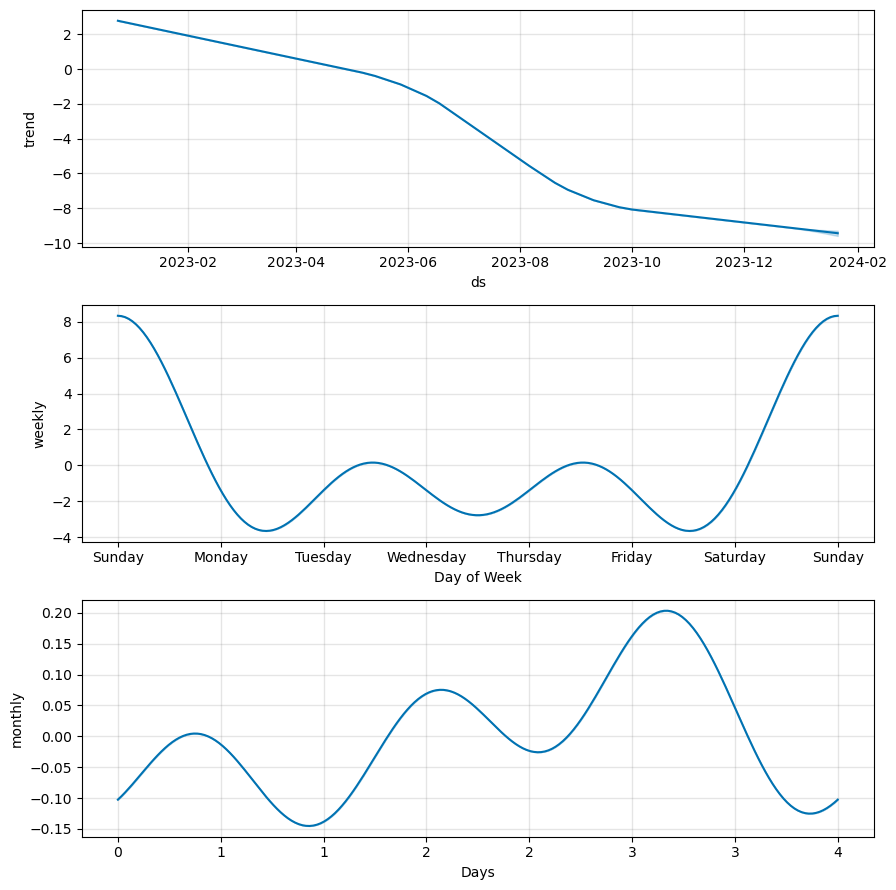

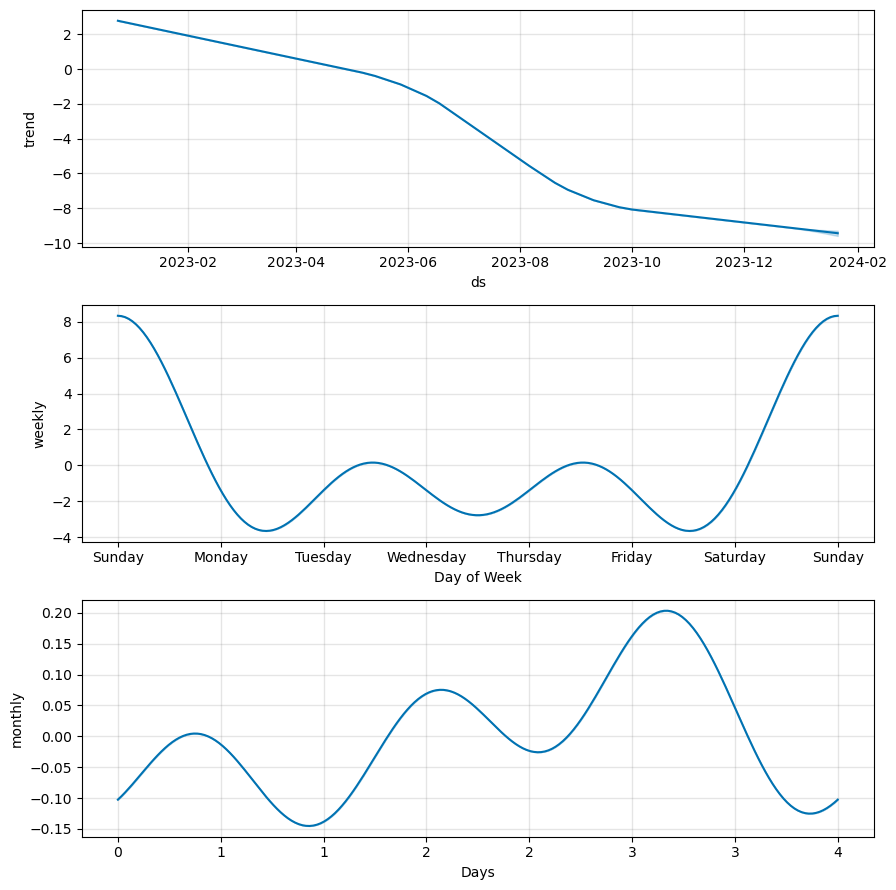

In [57]:
prophet_model.plot_components(forecast_df)

In [41]:
# Product with more Sales
df.groupby('Product')['Sales'].sum().sort_values(ascending=False).head()


Product
Tablet Blauw           715.0
KidsWatch Zwart        683.0
Tablet Rood            587.0
Xylofoon               371.0
Sterrenmobiel Blauw    294.0
Name: Sales, dtype: float64

Text(0.5, 1.0, 'Sales Distribution')

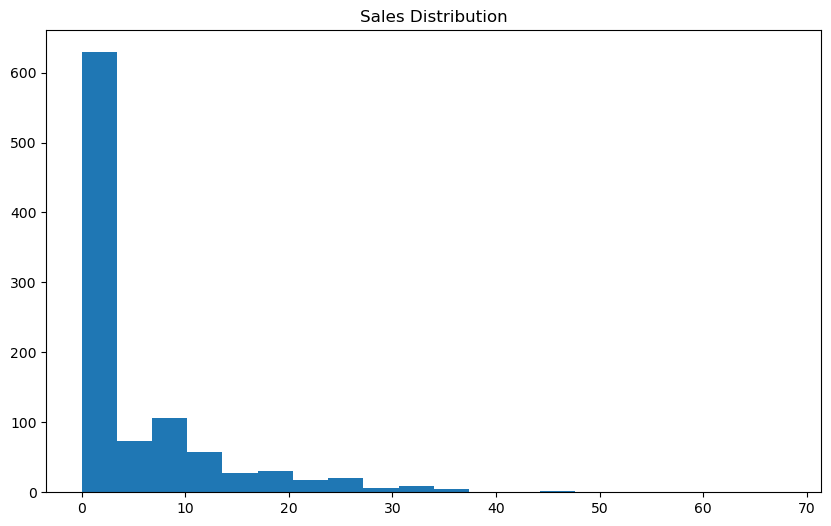

In [45]:
# plot sales distribution 
plt.figure(figsize=(10, 6))
plt.hist(df['Sales'], bins=20)
plt.title('Sales Distribution')
